<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/vgg_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building VGG Net to train on CIFAR100

**Mission Statement**
1. Building VGGNet from Scratch
2. Train a VGGNetwork with Cifar-100 Dataset

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 469.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 972.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.5 MB/s eta 0:00:00
    

ModuleNotFoundError: No module named 'sstorch'

## Introduction to VGGNet

The VGGNet is a convolution neural network (CNN) model developed by K. Simonyan and A. Zisserman from Oxford University and published it in a paper called [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In particular, VGG16 model - one of the model that supports 16 layers, achieve a test accuracy of 92.7% in ImageNet, a dataset containing more than 14 million training images across 1000 object classes. It is one of the top models from teh ILSVRC-2014 competition

VGG model differed from AlexNet in several ways. First, it used a tiny 3x3 receptive field with a 1-pixel stride—for comparison, AlexNet used an 11x11 receptive field with a 4-pixel stride. The 3x3 filters combine to provide the function of a larger receptive field. The benefit of using multiple smaller layers rather than a single large layer is that more non-linear activation layers accompany the convolution layers, improving the decision functions and allowing the network to converge quickly.

Second, VGG uses a smaller convolutional filter, which reduces the network's tendency to over-fit during training exercises. A 3x3 filter is the optimal size because a smaller size cannot capture left-right and up-down information. Thus, VGG is the smallest possible model to understand an image's spatial features. Consistent 3x3 convolutions make the network easy to manage.





## Details of VGG Architecture

VGGNets use tiny convolutional filters (3x3) in teh construction. 13 convolutional layers and 3 fully connected layers make up the VGG-16. Belows diagram shows the layers of VGG-Net Architecture.

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/vggnet_architecture.png?raw=true">

*   **Input**

    VGGNets receives a 224x224 image input. In the ImageNet competition, the model's creators kept the image input size constant by cropping a 224x224 section from the center of each image.
    
*   **Convolutional Layers**

    The convolutional filters of VGG use the smallest possible receptive field of 3×3. VGG also uses a 1×1 convolution filter as the input’s linear transformation.

*   **ReLU activation**

    VGGNet follows teh major innovation from AlexNet in using the Rectified Linear Unit Activation Function (ReLU) component. ReLU is a linear function that provides a matching output for positive inputs and outputs zero for negative inputs. VGG has a set convolution stride of 1 pixel to preserve the spatial resolution after convolution (the stride value reflects how many pixels the filter “moves” to cover the entire space of the image).

*   **Hidden layers**

    all the VGG network’s hidden layers use ReLU instead of Local Response Normalization like AlexNet. The latter increases training time and memory consumption with little improvement to overall accuracy.

*   **Pooling layers**

    A pooling layer follows several convolutional layers—this helps reduce the dimensionality and the number of parameters of the feature maps created by each convolution step. Pooling is crucial given the rapid growth of the number of available filters from 64 to 128, 256, and eventually 512 in the final layers.

*   **Fully connected layers**

    VGGNet includes three fully connected layers. The first two layers each have 4096 channels, and the third layer has 1000 channels, one for every class.






## VGG Configuration

The VGG network has 5 configurations named A to E. The depth of the configuration increases from left (A) to right (B), with more layers added.

Below table describe all the potential network architectures:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/vgg_configuration.png?raw=true">

Every configuration follows a common architectural pattern, differing only in depth. Network A  has 11 weight layers (8 convolutional layers and 3 fully connected layers), while network E has 19 weight layers (16 convolutional layers and 3 fully connected layers).

There are few convolutional layer channels—the number ranges from 64 channels in the first layer to 512 in the last layer (it increases by a factor of two for every max-pooling layer). The figure below shows the total number of parameters in millions.

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/vgg_parameters_number.png?raw=true">

## Buidling VGGNet from Scratch

We will build a VGGNet class for implimenting all 5 versions A-E of the VGGNet and apply model training on Cifar-100 dataset

Note that C is a special case where there are 1x1 and 3x3 convolutional layers with rest of the cases all using 3x3 kernel sizes

In [ ]:
import torch.nn as nn

class VGGNet(nn.Module):
    """VGGNet Implimentation
    Reference Paper: VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION
    Reference Link: https://arxiv.org/pdf/1409.1556v6.pdf
    """
    def __init__(self,
                 vgg_cfg: str,
                 in_channels: int = 3,
                 batch_norm: bool = False,
                 dropout: float = 0.5,
                 num_classes: int = 1000,
                 init_weights: bool = True):
        """Initialise VGGNet Class

        Args:
            vgg_cfg [str]: Configuration from original paper A-E
            in_channels [int]: num of color channels, Default 3
            batch_norm [bool]: Set true to use BatchNorm2d, Default False
            dropout [float]: probability of an element to be zeroed. Default 0.5
            num_classes [int]: num of classes to predict, Default 1000
            init_weight [bool]: initialise weights with kaiming_normal, Default True
        """
        super().__init__()

        # Initiatize cfgs for VGG Net including A-E
        # M - MaxPool2d with kernel_size=(2, 2) and stride=(2, 2)
        # tuple[k, v] - Conv2d with stride=1, padding=1, kernel_size=k and out_channels=v
        self.cfgs = {
            "A": [(3, 64), "M", (3, 128), "M", (3, 256), (3, 256), "M", (3, 512), (3, 512), "M", (3, 512), (3, 512), "M"],
            "B": [(3, 64), (3, 64), "M", (3, 128), (3, 128), "M", (3, 256), (3, 256), "M", (3, 512), (3, 512), "M", (3, 512), (3, 512), "M"],
            "C": [(3, 64), (3, 64), "M", (3, 128), (3, 128), "M", (3, 256), (3, 256), (1, 256), "M", (3, 512), (3, 512), (1, 512), "M", (3, 512), (3, 512), (1, 512), "M"],
            "D": [(3, 64), (3, 64), "M", (3, 128), (3, 128), "M", (3, 256), (3, 256), (3, 256), "M", (3, 512), (3, 512), (3, 512), "M", (3, 512), (3, 512), (3, 512), "M"],
            "E": [(3, 64), (3, 64), "M", (3, 128), (3, 128), "M", (3, 256), (3, 256), (3, 256), (3, 256), "M", (3, 512), (3, 512), (3, 512), (3, 512), "M", (3, 512), (3, 512), (3, 512), (3, 512), "M"],
        }

        # Make features layers depending on cfgs from vgg_cfg
        self.features = self.make_layers(vgg_cfg, in_channels, batch_norm)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes)
        )

        # Initialize neural network weights
        self.init_weights()

    def make_layers(self, vgg_cfg, in_channels, batch_norm):
        layers = nn.Sequential()
        # in_channels = self.in_channels
        for cfg in self.cfgs[vgg_cfg]:
            if cfg == 'M':
                layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
            else:
                kernel_size, out_channels = cfg
                layers.append(nn.Conv2d(in_channels=in_channels,
                                        out_channels=out_channels,
                                        kernel_size=kernel_size,
                                        stride=1,
                                        padding=1))
                if batch_norm:
                    layers.append(nn.BatchNorm2d(num_features=out_channels))
                layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels

        return layers

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Adding Batch Normalization to VGG

Note that original VGG doesnt have a batch norm layer in it because batch normalization didnt exist before VGG. Note that PyTorch has 2 versions of VGG model, one with Batch Normalization `vgg16_bn` and one without `vgg16`

Batch Normalization was introduced in [Batch Normalization: Accelerating Deep network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

Just like the need for standarzing features which helps training through having features of the same scale to create a smoother loss surface - a round bowl shape. Batch Normalization is a network layer that gets inserted between the hidden layers to prevent (or mitigate) an issue commonly called *internal convariate shift* - different distributions of activation values in different layers.

Instead of standardizing features - that is, the inputs to the model as a whole, batch normalization standardizes the activation values of a layer - that is, the inputs to the following layer - so that they have zero mean and unit standard deviation. It computes statistics (mean and standard deviation) for each mini-batch and perform an optional affine transformation - scaling and adding a constant to the stadardized output. Note that both scaling factor and constant are parameters learned by the model.

**Batch Normalization Algorithm**

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/bn_algorithm.png?raw=true">

<br/>

**During training**, we feed the network one mini-batch of data at a time. In the forward pass, each layer of the network processes that mini-batch of data. The Batch Norm layer processes its data as follows:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/bn_forward_operations.png?raw=true">


1.  Activations

    The activations from the previous layer are passed as input to the Batch Norm. There is one activation vector for each feature in the data.

2.  Calculate Mean and Variance

    For each activation vector separately, calculate the mean and variance of all the values in the mini-batch.

3.  Normalize

    Calculate the normalized values for each activation feature vector using the corresponding mean and variance. These normalized values now have zero mean and unit variance.

4.  Scale and Shift (affine transformation)

    This step is the huge innovation introduced by Batch Norm that gives it its power. Unlike the input layer, which requires all normalized values to have zero mean and unit variance, Batch Norm allows its values to be shifted (to a different mean) and scaled (to a different variance). It does this by multiplying the normalized values by a factor, gamma, and adding to it a factor, beta.

    What makes this innovation ingenious is that these factors are not hyperparameters (ie. constants provided by the model designer) but are trainable parameters that are learned by the network. In other words, each Batch Norm layer is able to optimally find the best factors for itself, and can thus shift and scale the normalized values to get the best predictions.

5.  Moving Average

    In addition, Batch Norm also keeps a running count of the Exponential Moving Average (EMA) of the mean and variance. During training, it simply calculates this EMA but does not do anything with it. At the end of training, it simply saves this value as part of the layer's state, for use during the Inference phase. The Moving Average calculation uses a scalar *momentum* denoted by alpha below. This is a hyperparameter that is used only for Batch Norm moving averages and should not be confused with the momentum that is used in the Optimizer.

6.  Backward Pass

    After the forward pass, we do the backward pass as normal. Gradients are calculated and updates are done for all layer weights, as well as for all beta and gamma parameters in the Batch Norm layers.

**During Inference**, we use the saved moving average of mean and variance of mini-batch during training to perform stardardization during inference. The moving average acts as a good proxy for hte mean and variance of the data.

<br/>

**Order of placement of Batch Norm Layer**

Note that Batch Norm layer can be placed before or after activation. The original paper placed it before. Both can achieve standardisation of distribution across different layers

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/bn_before_after.png?raw=true">

<br/>

**Regularization Effect**

While mitigating Internal Covariant Shift was the original motivation behind batch normalization. The fluctuation of the statistics during mini-batch training is actaully injecting randomness into the training process, thus havin ga regularizing effect and impacting positively the training of the model. Note that both batch normalizationa nd dropout layers have a regularizing effect, combining both layers may actually harm the mdoel performance.



**Effect of BatchNorm1d for a random dataset with 2 features**

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(23)
dummy_points = torch.randn(size=(200, 2)) + torch.rand(size=(200, 2)) * 2
dummy_labels = torch.randint(high=2, size=(200, 1))
dummy_ds = TensorDataset(dummy_points, dummy_labels)
dummy_dl = DataLoader(dataset=dummy_ds,
                      batch_size=64,
                      shuffle=True,
                      drop_last=True)

We create a `show_batch` function that plot out the histogram for both original features and normalised features after `BatchNorm`. We also show the `state_dict` after each run of batch which records running_mean, running_var and num_batches_tracked

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_batchnorm(batch_dl):

    # Define batch_normalizer as nn.BatchNorm1d
    batch_normalizer = nn.BatchNorm1d(num_features=2, affine=False, momentum=0.1)

    # Loop through num_of_batch
    for batch in batch_dl:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(batch_normalizer.state_dict())

        # Calculate the normalized batch
        batch_normalized = batch_normalizer(batch[0])

        # Plot histogram for each features with
        for i in range(2):
            features_original = batch[0][:, i]
            features_normalized = batch_normalized[:, i]
            axs[i].hist(features_original, bins=np.linspace(-3, 3, 15), alpha=.5, label='Original')
            axs[i].hist(features_normalized, bins=np.linspace(-3, 3, 15), alpha=.5, label='Standardized')
            axs[i].set_xlabel(f'Feature #{i}')
            axs[i].set_ylabel('# of points')
            axs[i].set_title(f'Original: mean={features_original.mean():.4f} std={features_original.std(unbiased=False):.4f}\n \
             Normalised: mean={features_normalized.mean():.4f} std={features_normalized.std(unbiased=False):.4f}\n')
            axs[i].legend()
            axs[i].set_ylim([0, 13])
            axs[i].label_outer()

        fig.tight_layout()


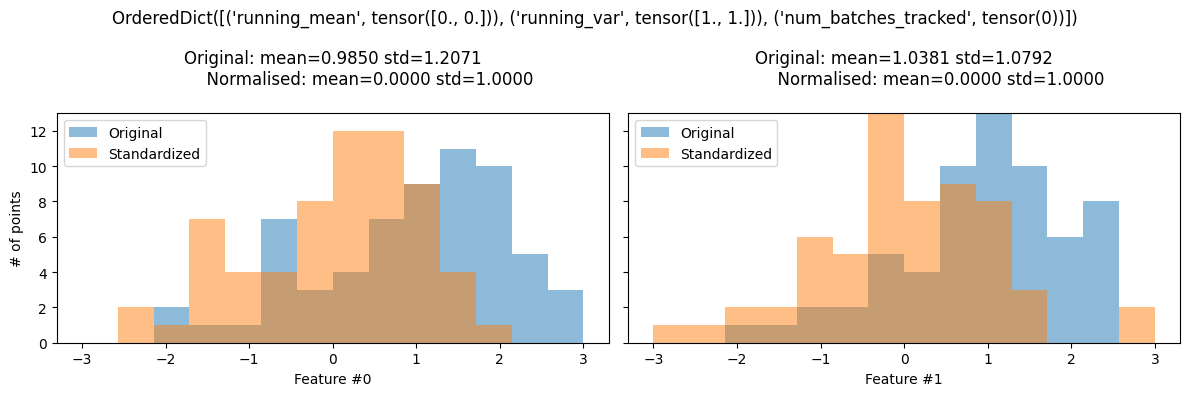

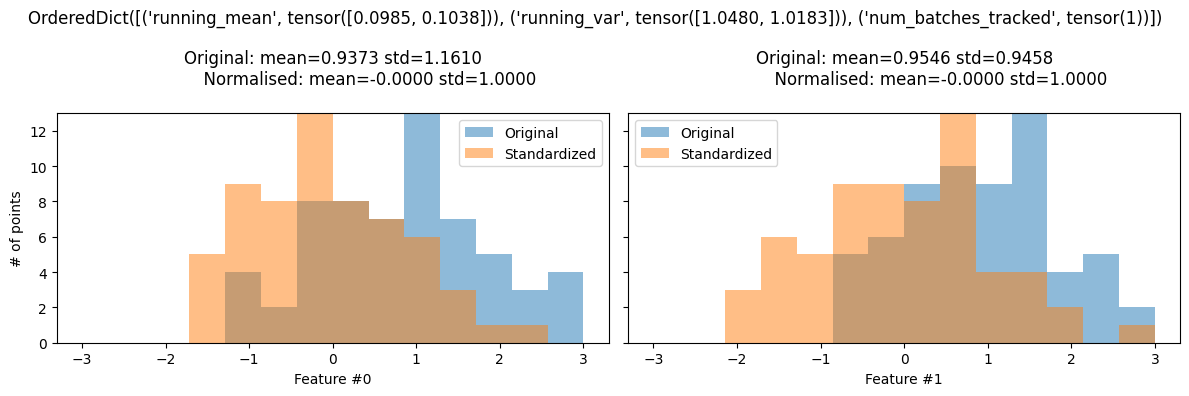

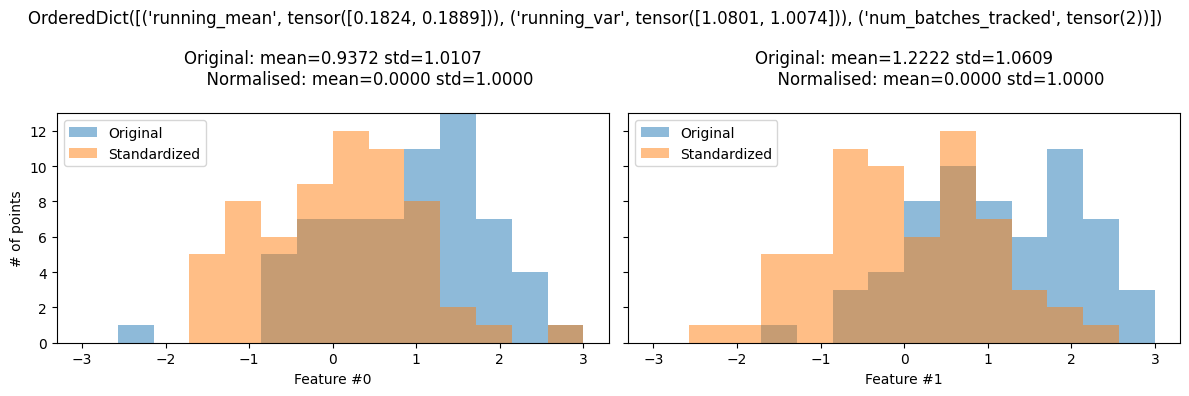

In [9]:
show_batchnorm(dummy_dl)

**BatchNorm2d vs BatchNorm1d**

While BatchNorm1d standardizes features, the BatchNorm2d standardizes channels. In `BatchNorm2d`, standardization is done over the **C Dimenion** of the NCHW. It has the same argument, and its num_features argument must match the number of channels of the input

## Prepare Cifar100 Dataset and DataLoader

In [3]:
import torchvision
from torchvision.datasets import CIFAR100
import torchvision.transforms as T
from torch.utils.data import DataLoader

train_ds = CIFAR100(root='data',
                    train=True,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    download=True)

# To get the mean and standard deviations of cifar10
data_shape = train_ds.data.shape
data_mean = train_ds.data.mean(axis=(0, 1, 2))/255
data_std = train_ds.data.std(axis=(0, 1, 2))/255

# Define transforms from PIL to Tensors
tfms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define transforms from PIL to Tensors with Data Augmentation
tfms_augmented = T.Compose([
    T.Resize(size=(224, 224)),
    T.TrivialAugmentWide(num_magnitude_bins=10),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define reverse transforms from Tensors to PIL (for visualisation)
rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std=list(map(lambda x: 1 / x, data_std))),
    T.Normalize(mean=list(map(lambda x: -x, data_mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

# Apply transforms to dataset
train_ds = CIFAR100(root='data',
                    train=True,
                    transform=tfms_augmented,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    transform=tfms,
                    download=True)


# Create DataLoader for train/valid dataset
train_dl = DataLoader(dataset=train_ds,
                      batch_size=128,
                      shuffle=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=128,
                      shuffle=False)

100%|██████████| 169001437/169001437 [00:12<00:00, 13098344.12it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Prepare for Model Training

In [4]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sstorch.vision.cifar100 import superclass_labels

# Define loss_fn
loss_fn = nn.CrossEntropyLoss()

# Define metric_fn that returns dictionary of accuracy, top_5_accuracy and accuracy_super
def metric_fn(y_logits, y):
    # Get Probs and Probabilities using softmax and argmax
    y_probs = y_logits.softmax(dim=-1).detach().cpu().numpy()
    y_preds = y_probs.argmax(axis=-1)
    y = y.detach().cpu().numpy()

    # Transform to superclass labels
    y_preds_super = superclass_labels[y_preds]
    y_super = superclass_labels[y]

    accuracy = accuracy_score(y, y_preds)
    top_5_accuracy = top_k_accuracy_score(y, y_probs, k=5, labels=list(range(100)))
    accuracy_super = accuracy_score(y_super, y_preds_super)
    return {'accuracy': accuracy,
            'top_5_accuracy': top_5_accuracy,
            'accuracy_super': accuracy_super}

# Retreive AlexNet from sstorch.vision
model = VGGNet(vgg_cfg='D', num_classes=100, batch_norm=True)

# Define optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-4)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

In [5]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGGNet (VGGNet)                          [128, 3, 224, 224]   [128, 100]           --                   True
├─Sequential (features)                  [128, 3, 224, 224]   [128, 512, 7, 7]     --                   True
│    └─Conv2d (0)                        [128, 3, 224, 224]   [128, 64, 224, 224]  1,792                True
│    └─BatchNorm2d (1)                   [128, 64, 224, 224]  [128, 64, 224, 224]  128                  True
│    └─ReLU (2)                          [128, 64, 224, 224]  [128, 64, 224, 224]  --                   --
│    └─Conv2d (3)                        [128, 64, 224, 224]  [128, 64, 224, 224]  36,928               True
│    └─BatchNorm2d (4)                   [128, 64, 224, 224]  [128, 64, 224, 224]  128                  True
│    └─ReLU (5)                          [128, 64, 224, 224]  [128, 64, 224, 224]  --                   --
│    └─MaxPool2d (

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 1.80E-03 | Lowest Loss: 8.08E-04


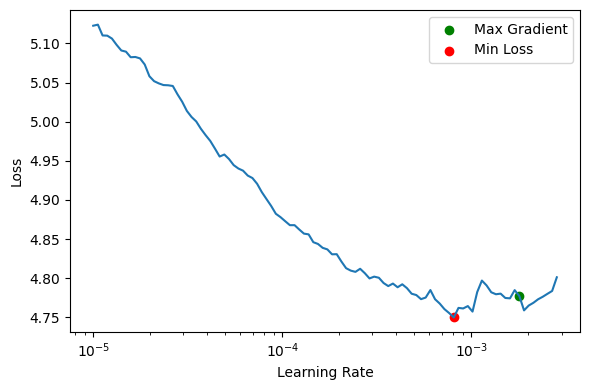

In [5]:
learner.lr_range_test(end_lr=3e-3, start_lr=1e-5)

In [ ]:
learner.train(10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-04 | train_loss: 4.326 | valid_loss: 3.708 
train_metric: {'accuracy': 0.048, 'top_5_accuracy': 0.18, 'accuracy_super': 0.135}
valid_metric: {'accuracy': 0.127, 'top_5_accuracy': 0.377, 'accuracy_super': 0.254}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-04 | train_loss: 3.858 | valid_loss: 3.272 
train_metric: {'accuracy': 0.107, 'top_5_accuracy': 0.321, 'accuracy_super': 0.234}
valid_metric: {'accuracy': 0.213, 'top_5_accuracy': 0.5, 'accuracy_super': 0.355}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-04 | train_loss: 3.557 | valid_loss: 2.938 
train_metric: {'accuracy': 0.154, 'top_5_accuracy': 0.41, 'accuracy_super': 0.291}
valid_metric: {'accuracy': 0.264, 'top_5_accuracy': 0.576, 'accuracy_super': 0.414}
----------------------------------------------------------------------------------------------------
Epoch